In [20]:
import poppy
import astropy.units as u
import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt
import logging
%matplotlib inline
logging.basicConfig()
logging.getLogger("poppy").setLevel(logging.DEBUG)
def get_intensity(wf):
    return poppy.utils.removePadding(wf.intensity,oversample=wf.oversample)

def get_amplitude(wf):
    return poppy.utils.removePadding(wf.amplitude,oversample=wf.oversample)

def get_phase(wf):
    return poppy.utils.removePadding(wf.phase,oversample=wf.oversample)
from poppy.poppy_core import PlaneType

class VVC(poppy.AnalyticOpticalElement):

    """ Defines an ideal circular pupil aperture
    Parameters
    ----------
    name : string
        Descriptive name
    radius : float
        Radius of the pupil, in meters. Default is 1.0
    pad_factor : float, optional
        Amount to oversize the wavefront array relative to this pupil.
        This is in practice not very useful, but it provides a straightforward way
        of verifying during code testing that the amount of padding (or size of the circle)
        does not make any numerical difference in the final result.
    """

    @poppy.utils.quantity_input(radius=u.meter)
    def __init__(self, name=None, 
                 radius=1.0*u.meter,
                 shift=0.25,
                 pad_factor=1.0,
                 outside=0,
                 planetype=poppy.poppy_core.PlaneType.unspecified, **kwargs):

        if name is None:
            name = "Circle, radius={}".format(radius)
        super(VVC, self).__init__(name=name, planetype=planetype, **kwargs)
        self.radius=radius
        self.shift=shift
        self.outside=outside
        # for creating input wavefronts - let's pad a bit:
        self.pupil_diam = pad_factor * 2 * self.radius

    def get_opd(self, wave, units='meters'):
        """ Compute the transmission inside/outside of the aperture.
        """
        if not isinstance(wave, poppy.Wavefront):  # pragma: no cover
            raise ValueError(" get_opd must be called with a Wavefront "
                             "to define the spacing")
        y, x = self.get_coordinates(wave)
        radius = self.radius.to(u.meter).value
        r = np.sqrt(x ** 2 + y ** 2)
        del x
        del y

        w_outside = np.where(r > radius)
        del r
        self.opd = (self.shift*wave.wavelength*np.ones(wave.shape)).to(u.m).value
        self.opd[w_outside] = self.outside
        return self.opd

DEBUG:poppy:  Multiplied WF by phasor for Pupil plane: SimpleJWST (Analytic)
DEBUG:poppy:  Propagating wavefront to Image plane: unnamed optic (Analytic). 
DEBUG:poppy:    Padded WF array for oversampling by 8x
DEBUG:poppy:using pyfftw FFT of (2048, 2048) array, FFT_direction=forward
DEBUG:poppy:    FFT_2D: FFT in 7.711910 s, full function  in 7.809 s


<Quantity 0.00218165 arcsec / pix>

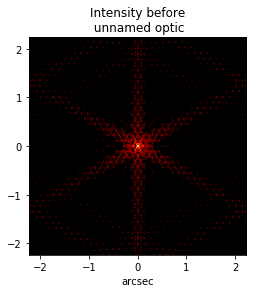

In [2]:
#wfe_file="data/segment_jitter/guyonHex_blaurockPSD_x1.fits"
#lgsa=fits.open(wfe_file)
#lgsa[0].data=lgsa[0].data*wl.to(u.nm).value/(2*np.pi)
diam=6.5*u.m
DM_size=10*u.cm#DM size
f=10
oversample=8
npix=256
wl=550*u.nm
mask_radius=1*u.mm

wf_MFT = poppy.Wavefront(diam=diam,
                            oversample=oversample,
                            npix=npix,
                            wavelength=wl)
wf_MFT *= poppy.MultiHexagonAperture("SimpleJWST",rings=2,center=True)
from poppy.poppy_core import PlaneType


im=poppy.OpticalElement(planetype=PlaneType.image,oversample=oversample)
wf_MFT.propagateTo(im)
wf_MFT.display()
wf_MFT.pixelscale

In [3]:

plate_scale=wf_MFT.diam*f/u.radian*wf_MFT.pixelscale
plate_scale.decompose()
im_size=npix*u.pix*plate_scale.decompose()



DEBUG:poppy:Padded WF array for oversampling by 8, to (2048, 2048).
DEBUG:poppy:Initialized: Quadratic Lens, fl =6.50e+01 m
DEBUG:poppy:------ Applying Lens: Quadratic Lens ------
DEBUG:poppy:  Pre-Lens Beam Parameters: w_0:6.500e+00 m, z_w0=0.000e+00 m
z=0.000e+00 m, z_r=2.413e+08 m
DEBUG:poppy:  Beam radius at Quadratic Lens =6.50e+00 m
DEBUG:poppy: input flat wavefront and Quadratic Lens has output beam curvature of =-6.50e+01 m
DEBUG:poppy:Quadratic Lens has a curvature of =-6.50e+01 m
DEBUG:poppy:Quadratic Lens has a curved output wavefront, with waist at 64.99999999999528 m
DEBUG:poppy:Post Optic Parameters:w_0:1.751e-06 m, z_w0=6.500e+01 m
z=0.000e+00 m, z_r=1.751e-05 m
DEBUG:poppy:Set output beam focal length to 65.0 m
DEBUG:poppy:Inside Rayleigh distance to Outside Rayleigh distance.
DEBUG:poppy:Applying spherical phase curvature =8.97e+14 m
DEBUG:poppy:Applying spherical lens phase =1.12e-15 1 / m
DEBUG:poppy:max_rsqd =5.41e+03
DEBUG:poppy:  Multiplied WF by phasor for Optic:

w_0:1.751e-06 m, z_w0=6.500e+01 m
z=6.500e+01 m, z_r=1.751e-05 m


DEBUG:poppy:max_rsqd =2.48e-07
DEBUG:poppy:  Multiplied WF by phasor for Optic: Quadratic Wavefront Curvature Operator
DEBUG:poppy:using pyfftw FFT of (2048, 2048) array, FFT_direction=forward
DEBUG:poppy:    FFT_2D: FFT in 0.187910 s, full function  in 0.203 s
DEBUG:poppy:------ Propagated to plane of type PlaneType.intermediate at z = 6.60e+01 m ------


w_0:1.751e-06 m, z_w0=6.500e+01 m
z=6.600e+01 m, z_r=1.751e-05 m


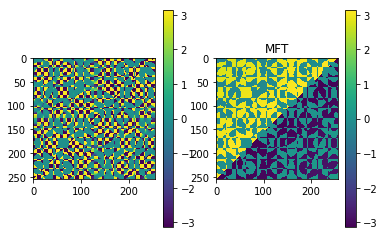

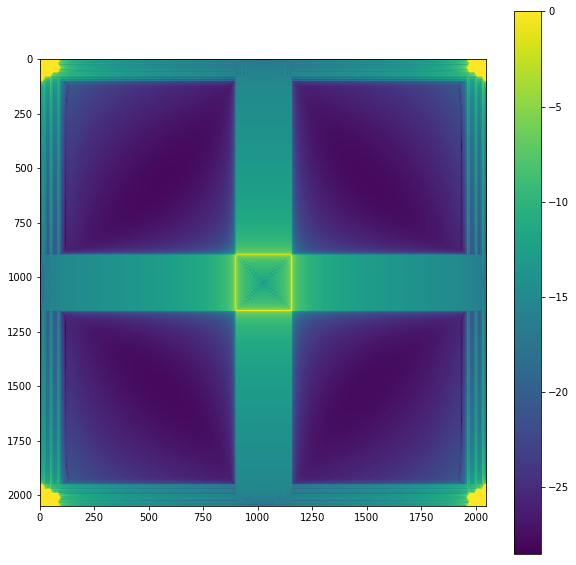

In [48]:
wf = poppy.FresnelWavefront(beam_radius=diam,
                            oversample=oversample,
                            npix=npix,
                            wavelength=wl)
wf *= poppy.QuadraticLens(f_lens=diam*f)

wf.propagate_fresnel(diam*f)
wf.wavefront.real=wf_MFT.wavefront.real

#wf.wavefront.imag=0


plt.subplot(121)
plt.imshow(get_phase(wf))
plt.colorbar()
plt.subplot(122)
plt.title("MFT")
plt.imshow(get_phase(wf_MFT))
plt.colorbar()



print(wf.param_str)

wf.propagate_fresnel(DM_size*f)
#wf *= poppy.QuadraticLens(f_lens=DM_size*f)


print(wf.param_str)

plt.figure(figsize=[10,10])
plt.imshow(np.log10(wf.intensity))
plt.colorbar()

In [12]:
#wf = poppy.FresnelWavefront(beam_radius=(wl/wf_MFT.diam)*f*wf_MFT.diam/5,
                            oversample=oversample,
                            npix=npix,
                            wavelength=wl)
wf.wavefront=wf_MFT.wavefront

DEBUG:poppy:Padded WF array for oversampling by 8, to (2048, 2048).


DEBUG:poppy:Beginning Fresnel Prop. Waist at z = 64.99999999999528 m
DEBUG:poppy:  Plane to Spherical, inside Z_R to outside Z_R
DEBUG:poppy:  Starting Pixelscale: 343.74999999997505 nm / pix
DEBUG:poppy:Skipping small dz = 0.0 m
DEBUG:poppy:Waist to Spherical propagation, dz=1.0 m
DEBUG:poppy:Applying spherical phase curvature =1.00e+00 m
DEBUG:poppy:Applying spherical lens phase =1.00e+00 1 / m


w_0:1.751e-06 m, z_w0=6.500e+01 m
z=6.500e+01 m, z_r=1.751e-05 m


DEBUG:poppy:max_rsqd =2.48e-07
DEBUG:poppy:  Multiplied WF by phasor for Optic: Quadratic Wavefront Curvature Operator
DEBUG:poppy:using pyfftw FFT of (2048, 2048) array, FFT_direction=forward
DEBUG:poppy:    FFT_2D: FFT in 0.187954 s, full function  in 0.204 s
DEBUG:poppy:------ Propagated to plane of type PlaneType.intermediate at z = 6.60e+01 m ------


w_0:1.751e-06 m, z_w0=6.500e+01 m
z=6.600e+01 m, z_r=1.751e-05 m


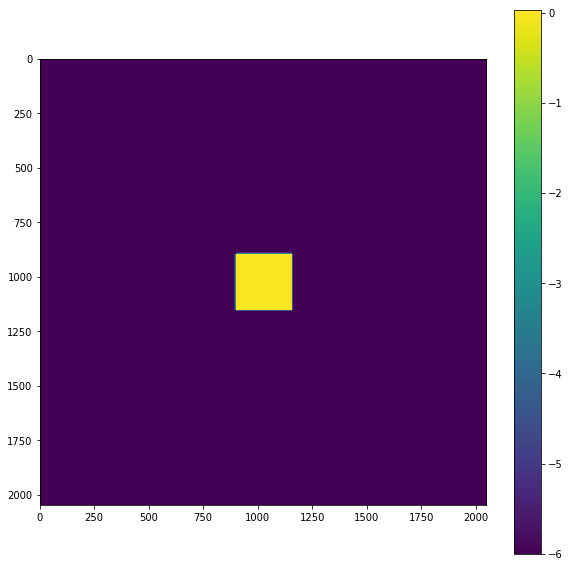

In [17]:
print(wf.param_str)
wf.propagate_fresnel(DM_size*f)
#wf *= poppy.QuadraticLens(f_lens=DM_size*f)


print(wf.param_str)

plt.figure(figsize=[10,10])
plt.imshow(np.log10(wf.intensity),vmin=-6)
plt.colorbar()

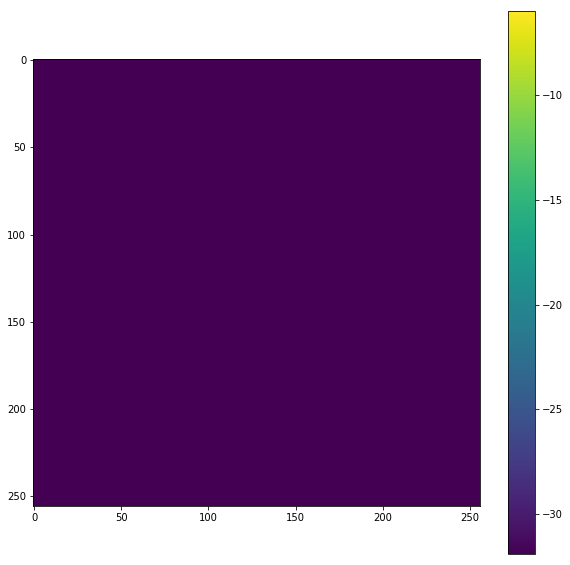

In [6]:
plt.figure(figsize=[10,10])
plt.imshow(np.log10(get_intensity(wf)),vmin=-6)
plt.colorbar()

'/Users/edouglas/github/poppy/poppy/__init__.py'

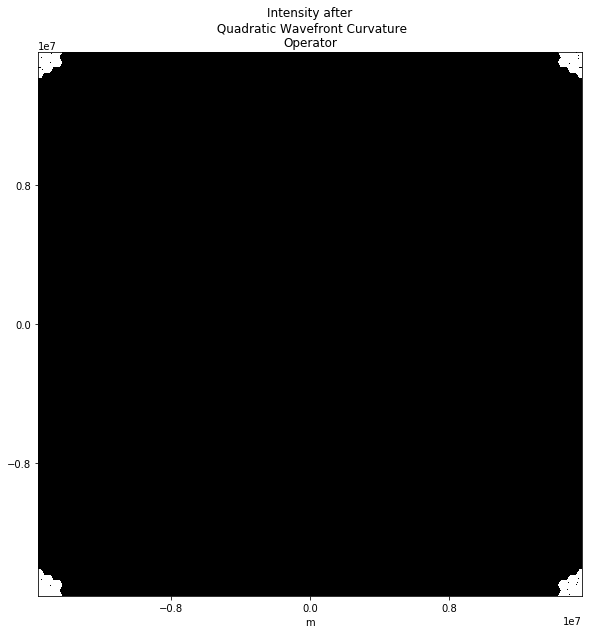

In [7]:
plt.figure(figsize=[10,10])
wf.display(what='intensity')
poppy.__file__

In [8]:
DM_size*f

<Quantity 100. cm>

DEBUG:poppy:Padded WF array for oversampling by 4, to (2048, 2048).
DEBUG:poppy:  Multiplied WF by phasor for Pupil plane: SimpleJWST (Analytic)
DEBUG:poppy:Initialized: Quadratic Lens, fl =9.75e+01 m
DEBUG:poppy:------ Applying Lens: Quadratic Lens ------
DEBUG:poppy:  Pre-Lens Beam Parameters: w_0:6.500e+00 m, z_w0=0.000e+00 m
z=0.000e+00 m, z_r=2.413e+08 m
DEBUG:poppy:  Beam radius at Quadratic Lens =6.50e+00 m
DEBUG:poppy: input flat wavefront and Quadratic Lens has output beam curvature of =-9.75e+01 m
DEBUG:poppy:Quadratic Lens has a curvature of =-9.75e+01 m
DEBUG:poppy:Quadratic Lens has a curved output wavefront, with waist at 97.49999999998408 m
DEBUG:poppy:Post Optic Parameters:w_0:2.626e-06 m, z_w0=9.750e+01 m
z=0.000e+00 m, z_r=3.939e-05 m
DEBUG:poppy:Set output beam focal length to 97.5 m
DEBUG:poppy:Inside Rayleigh distance to Outside Rayleigh distance.
DEBUG:poppy:Applying spherical phase curvature =5.97e+14 m
DEBUG:poppy:Applying spherical lens phase =1.67e-15 1 / m
DE

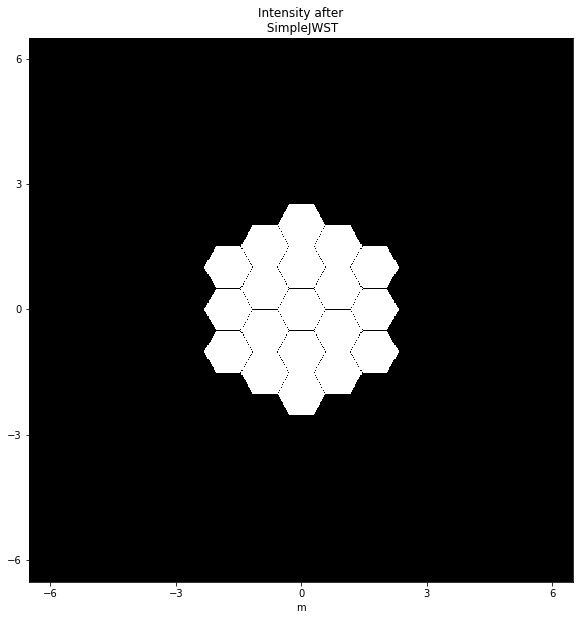

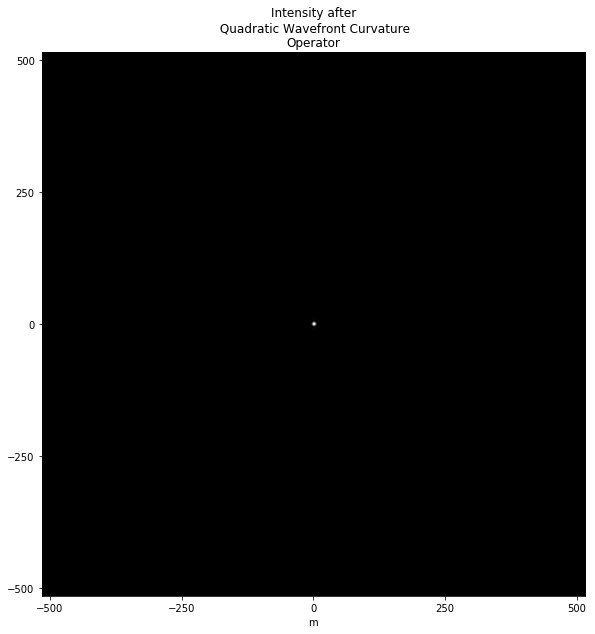

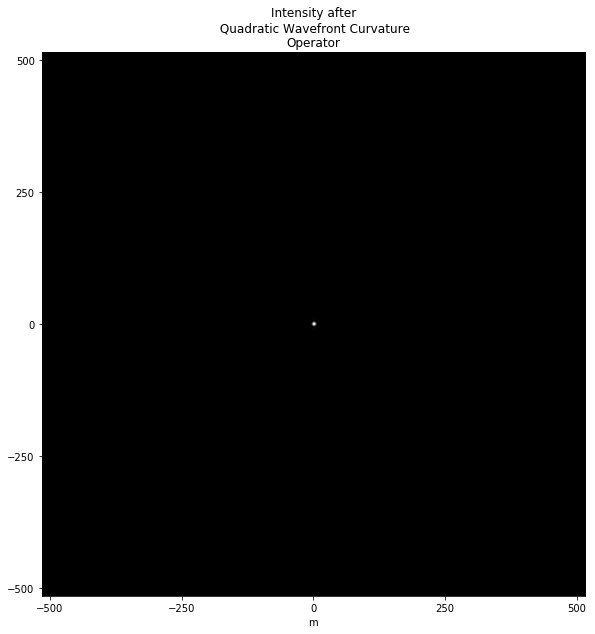

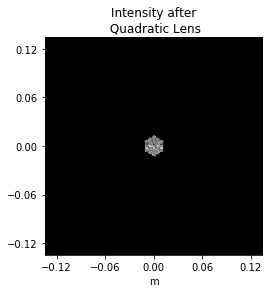

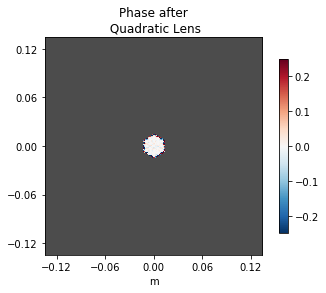

In [50]:
#wfe_file="data/segment_jitter/guyonHex_blaurockPSD_x1.fits"
#lgsa=fits.open(wfe_file)
#lgsa[0].data=lgsa[0].data*wl.to(u.nm).value/(2*np.pi)
beam_r=6.5*u.m
DM_size=350*u.micron*96#DM size
f=15
oversample=4
npix=512
wl=550*u.nm
mask_radius=1*u.mm
wf = poppy.FresnelWavefront(beam_radius=beam_r,
                            oversample=oversample,
                            npix=npix,
                            wavelength=wl)
#wf*=poppy.ZernikeWFE(radius=beam_r.to(u.m).value,coefficients=[0,0,0,0,0,1e-7])

#wf *= poppy.FITSOpticalElement(opd=lgsa,opdunits="nm")
wf *= poppy.MultiHexagonAperture("SimpleJWST",rings=2,center=True)
#input_wf_abb_tilted=wf.copy()

phase=np.ma.masked_array(poppy.utils.removePadding(wf.copy().phase,
                                                   oversample=wf.oversample),
                        )
phase.mask= phase ==0




plt.figure(figsize=[10,10])

wf.display(what='intensity')
wf *= poppy.QuadraticLens(f_lens=beam_r*f)
wf.propagate_fresnel(beam_r*f)

plt.figure(figsize=[10,10])

wf.display(what='intensity')


#tune the shift and the size of the mask here:
#wf *= VVC(radius=mask_radius,shift=0.25)

plt.figure(figsize=[10,10])
wf.display(what='intensity')


wf.propagate_fresnel(f*DM_size)

wf *= poppy.QuadraticLens(f_lens=f*DM_size)
plt.figure()
wf.display(what='intensity')
plt.figure()


wf.display(what='phase',colorbar=True)



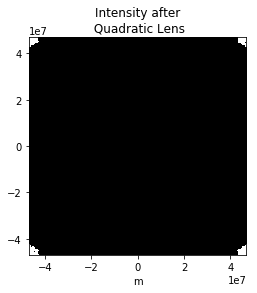

In [10]:
wf.display()

NameError: name 'phase' is not defined

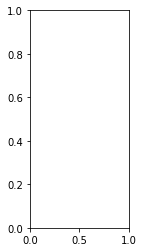

In [11]:
ax1=plt.subplot(131)
inp_inten=np.ma.masked_array(get_intensity(wf),mask=phase.mask)-1
plt.imshow(inp_inten,interpolation='nearest')

plt.title("Input ")
cm=plt.colorbar( format='1%2.1e',orientation="horizontal",label="Normalized Intensity")
cm.set_ticks([inp_inten.min(), inp_inten.mean(),inp_inten.max()])




ax2=plt.subplot(132)


plt.title("Input Phase")# [rad]")
plt.imshow(phase,interpolation="nearest")#,vmax=1e-6,vmin=-1e-6)
cm=plt.colorbar( format='%2.1e',orientation="horizontal",label="Radians")

cm.set_ticks([np.nanmin(phase), phase.mean(),phase.max()])
#,label="rad")
ax3=plt.subplot(133)
plt.title("Output")# [rad]")
out=np.ma.masked_array(np.fliplr(np.flipud((get_intensity(wf))+0.5),),mask=phase.mask)-.5

plt.imshow(out,interpolation='nearest',vmin=np.nanmin(phase), vmax=phase.max())
                      # vmax=1e-6,vmin=-1e-6)


cm=plt.colorbar( format='%2.1e',orientation="horizontal",label="Radians")
cm.set_ticks([np.nanmin(phase), phase.mean(),phase.max()])



for ax in [ax1,ax2,ax3]:
    ax.set_yticklabels("")
    ax.set_xticklabels("")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')

    #make boarder thickness 0?

#plt.tight_layout()
#plt.savefig("figs/ZWFS_gaussian_illum_segmented.pdf",bbox_inches="tight")

In [ ]:
ga=poppy.MultiHexagonAperture

In [ ]:
f*DM_size